## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [109]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [110]:
# (re-)load layers
# %run modules.ipynb
from modules import * 

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

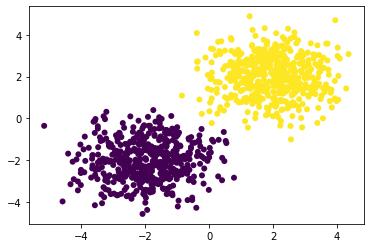

In [111]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [112]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())
# # net.add(SoftMax())
# criterion = ClassNLLCriterion()
# print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 10))
net.add(ReLU())
net.add(Linear(10, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 10
ReLU
Linear 10 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [113]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

criterion = ClassNLLCriterion()

In [114]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

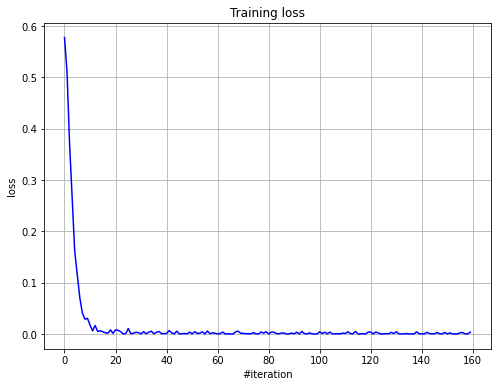

Current loss: 0.003616


In [115]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.grid(':')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [116]:
import mnist_

X_train, y_train, X_val, y_val, X_test, y_test = mnist_.load_dataset()

One-hot encode the labels first.

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


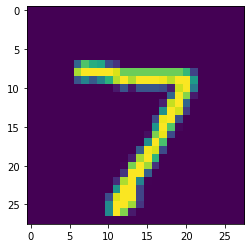

In [117]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(y_train.reshape(y_train.shape[0], 1))
y_train = enc.transform(y_train.reshape(y_train.shape[0], 1)).toarray()

enc.fit(y_test.reshape(y_test.shape[0], 1))
y_test = enc.transform(y_test.reshape(y_test.shape[0], 1)).toarray()

enc.fit(y_val.reshape(y_val.shape[0], 1))
y_val = enc.transform(y_val.reshape(y_val.shape[0], 1)).toarray()

plt.imshow(X_test.reshape((X_test.shape[0], 28, 28))[0])
print(y_test[0])

In [118]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_train.shape

(50000, 784)

In [119]:
X_test = X_test.reshape((X_test.shape[0], -1))
X_test.shape

(10000, 784)

In [120]:
X_val = X_val.reshape((X_val.shape[0], -1))
X_val.shape

(10000, 784)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [121]:
n_features = X_train.shape[1]
n_classes = y_train.shape[1]
print(n_features, n_classes)

784 10


In [122]:
import tqdm

def train_loop(net, X, Y, name, n_epoch=10, batch_size=32, criterion = ClassNLLCriterion(), 
               optimizer=sgd_momentum, optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}, 
               optimizer_state = {}):
    
    loss_history = []
    
    optimizer_state = {}
    for i in tqdm.tqdm(range(n_epoch)):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)      

            loss_history.append(loss)
            

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 5))

        plt.title(f"Training loss {name}")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)
        
    return loss_history

In [129]:
def layers2net(activation, has_batch_norm = False):
    net = Sequential()
    net.add(Linear(n_features, 60))
    
    if has_batch_norm:
        net.add(BatchNormalization(alpha=0.9))
        net.add(ChannelwiseScaling(60))
        
    net.add(activation())
    net.add(Linear(60, n_classes))
    net.add(LogSoftMax())
    return net

def layers3net(activation):
    net = Sequential()
    net.add(Linear(n_features, 40))
    net.add(activation())
    net.add(Linear(40, 20))
    net.add(activation())
    net.add(Linear(20, n_classes))
    net.add(LogSoftMax())
    return net

In [130]:
functions = [ReLU, ELU, LeakyReLU, SoftPlus]

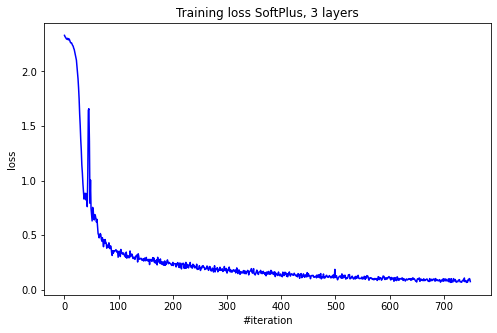

100%|███████████████████████████████████████████| 30/30 [00:19<00:00,  1.57it/s]

Current loss: 0.073345
CPU times: user 2min 30s, sys: 13 s, total: 2min 43s
Wall time: 2min 42s


In [131]:
%%time

all_losses_2={}
all_losses_3={}

for activation in functions:
    net = layers2net(activation)
    losses = train_loop(net, X_train, y_train, name=f'{activation.__name__}, 2 layers', batch_size=2048, n_epoch=30)
    all_losses_2[f'{activation.__name__}, 2 layers'] = losses
    
    net = layers3net(activation)
    losses = train_loop(net, X_train, y_train, name=f'{activation.__name__}, 3 layers', batch_size=2048, n_epoch=30)
    all_losses_3[f'{activation.__name__}, 3 layers'] = losses

In [136]:
def plot_losses(all_losses):
    plt.figure(figsize=(15, 15))
    
    for label in all_losses.keys():
        plt.plot(all_losses[label], label=label)
    
    plt.xlabel('#iter')
    plt.ylabel('Loss')
    plt.title('Train losses')
    plt.yscale('log')
    plt.legend()
    plt.grid(':')
    plt.show()

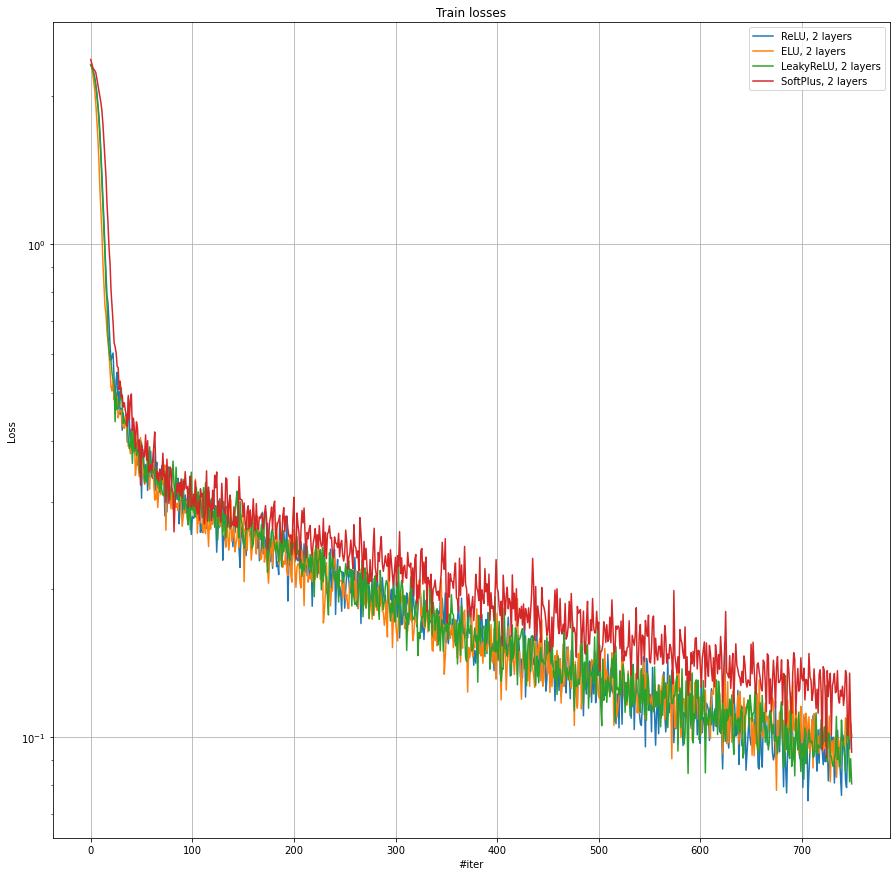

In [137]:
plot_losses(all_losses_2)

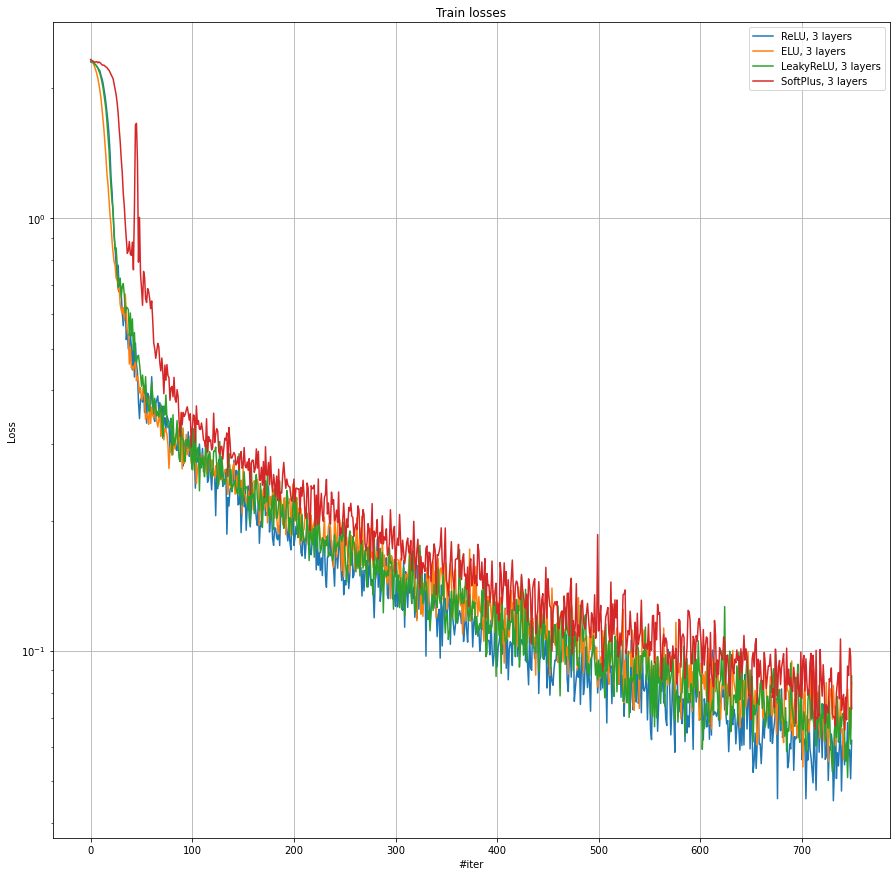

In [138]:
plot_losses(all_losses_3)

В обоих случаях трехслойной сети и двухслойной, лучше всех(быстрее по итерациям) показывают функции активации ReLU, LeakyReLU, хуже всех SoftPlus.

Добавим batch_norm и сравним сходимости для лучшей ф-ии активации -- для ReLU:

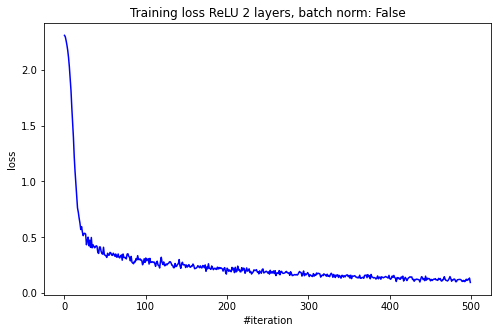

100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]

Current loss: 0.095920
CPU times: user 27.8 s, sys: 2.71 s, total: 30.5 s
Wall time: 30.5 s


In [139]:
%%time
all_losses_2_bn={}
for activation in ((ReLU, True),(ReLU, False)):
    net = layers2net(activation[0], has_batch_norm=activation[1])
    losses = train_loop(net, X_train, y_train, name=f'{activation[0].__name__} 2 layers, batch norm: {activation[1]}', batch_size=2046, n_epoch=20)
    all_losses_2_bn[f'{activation[0].__name__} 2 layers, batch norm: {activation[1]}'] = losses
    

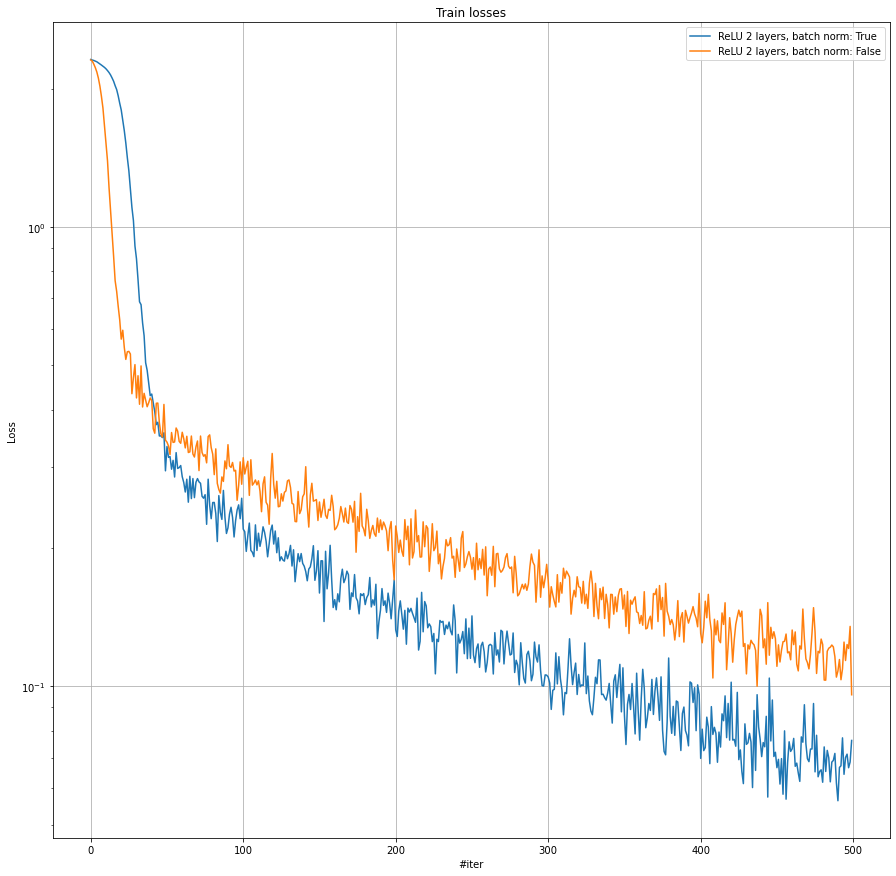

In [140]:
plot_losses(all_losses_2_bn)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

 Во всех случаях лучше свех себя показывают LeakyRelu и Relu. Однако уменьшение loss(сам градиентный спуск) достаточно шумный, чтобы графики не смегиваались, возьмем batch_size сильно больше, тогда градиентный спуск по времени будет чуть медленнее из-за обсчета, но направленнее.

 Да, тестирование специально проводилось с одинаковыми batch size и n_epoch, при использовании batch_norm двуслойная сеть сеть легко преодолела ошибку в 1e-1, а без него -- нет. Также была исследовано влияние количества слоев сети, трислойная сеть(каждый был в некотором смысле уже, чем у двухслолйной) достигла меньшего lossa за то же число операций. Осталось только проверить, что не случилось переобучения, для этого чуть ниже подкорректируем train loop.

Теперь сравним два оптимизатора sgd with momentum, adam. Тестирование будем проводить на модели с ф-ей активации ReLU и слоем нормализации.

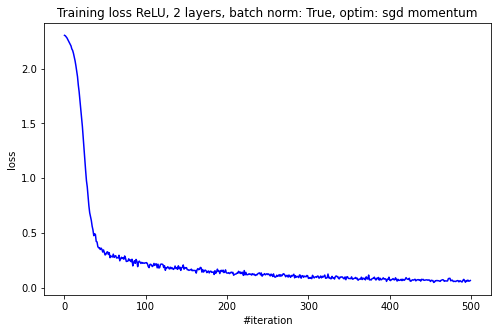

100%|███████████████████████████████████████████| 20/20 [00:15<00:00,  1.29it/s]

Current loss: 0.066651
CPU times: user 14.3 s, sys: 1.19 s, total: 15.5 s
Wall time: 15.5 s


In [149]:
%%time
all_losses_optim={}

net = layers2net(ReLU, has_batch_norm=True)
losses = train_loop(net, X_train, y_train, name=f'ReLU, 2 layers, batch norm: True, optim: sgd momentum', batch_size=2048, n_epoch=20)
all_losses_optim[f'ReLU, 2 layers, batch norm: True, optim: sgd momentum'] = losses    

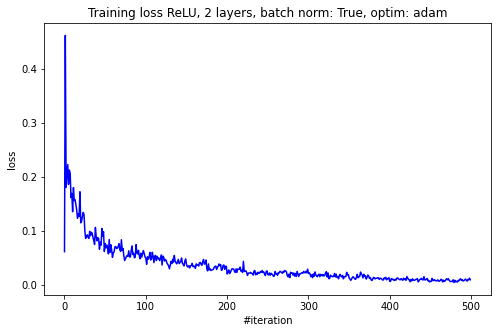

100%|███████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]

Current loss: 0.009039
CPU times: user 14.2 s, sys: 1.15 s, total: 15.4 s
Wall time: 15.3 s


In [150]:
%%time
losses = train_loop(net, X_train, y_train, name=f'ReLU, 2 layers, batch norm: True, optim: adam', 
                    optimizer=adam_optimizer, optimizer_config={'learning_rate':1e-2, 'beta1':0.9, 'beta2':0.99, 'epsilon':1e-6}, batch_size=2048, n_epoch=20)
all_losses_optim[f'ReLU, 2 layers, batch norm: True, optim: adam'] = losses


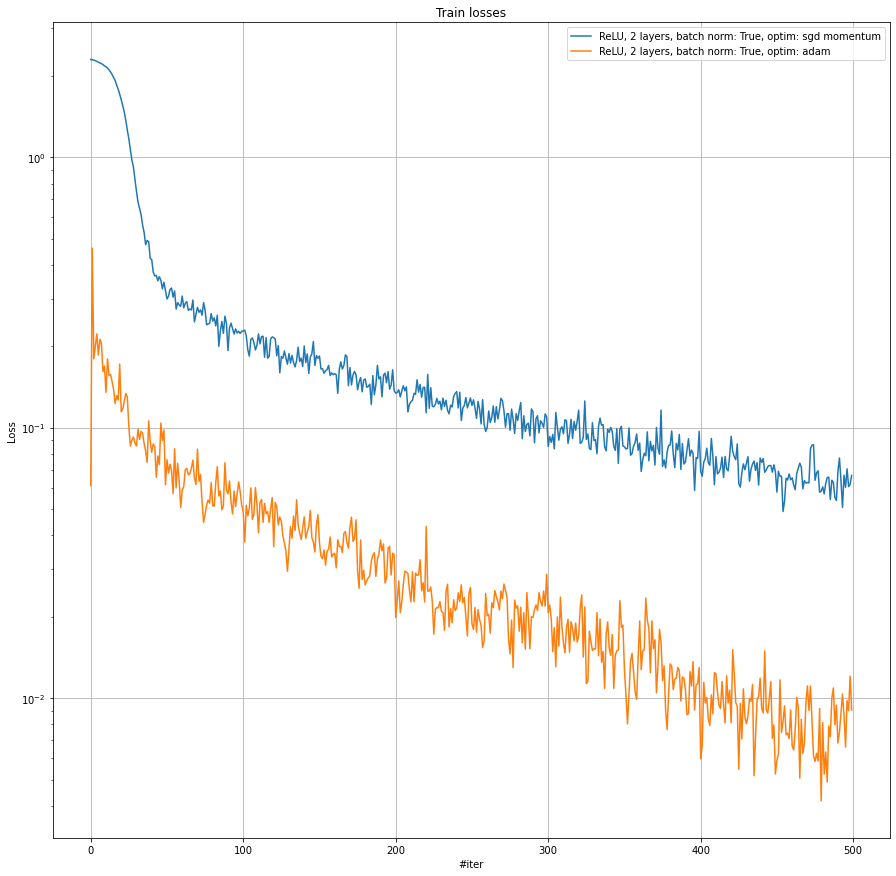

In [151]:
plot_losses(all_losses_optim)

Adam с дефолтными параметрами показал результат по итерациям на порядок лучше, чем sgd & momentum, однако также стоит посмотреть на время, за которое выполнялиь итерации, оно приблизительно равно в случаях с разными оптимизаторами, значит все же adam однозначно побеждает.

Добавим валидацию, чтобы контролировать переобучение.

In [153]:
import tqdm

def val_train_loop(net, X, Y, X_val, Y_val, name, n_epoch=10, batch_size=32, criterion = ClassNLLCriterion(), 
               optimizer=sgd_momentum, optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}, 
               optimizer_state = {}):
    
    loss_history = []
    val_loss_history = []
    
    optimizer_state = {}
    for i in tqdm.tqdm(range(n_epoch)):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)      

            loss_history.append(loss)
            
            net.evaluate()
            val_predictions = net.forward(X_val)
            val_loss = criterion.forward(val_predictions, Y_val)
            val_loss_history.append(val_loss)
            net.train()
            
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 5))

        plt.title(f"Training and validating loss {name}")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b', label='train loss')
        plt.plot(val_loss_history, 'r', label='validation loss')
        
        plt.show()

        print(f'Current validation loss: {val_loss}, train loss: {loss}')
        
    return val_loss_history

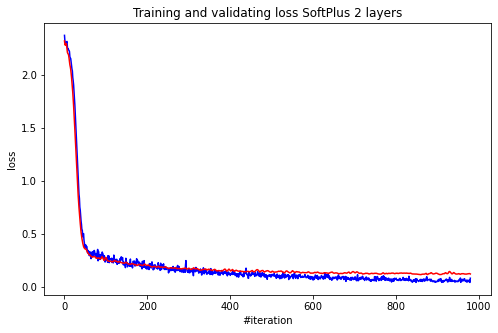

100%|███████████████████████████████████████████| 20/20 [01:07<00:00,  3.36s/it]

Current validation loss: 0.12142023066521743, train loss: 0.08160893660383779
CPU times: user 4min 4s, sys: 27.1 s, total: 4min 31s
Wall time: 4min 31s


In [158]:
%%time
all_losses_2_bn_bs_val={}

for activation in activations:
    net = layers2net(activation, has_batch_norm=True)
    losses = val_train_loop(net, X_train, y_train, X_val=X_val, Y_val=y_val, name=f'{activation.__name__} 2 layers', batch_size=1028, n_epoch=20)
    all_losses_2_bn_bs_val[f'{activation.__name__} 2 layers, batch norm: True'] = losses
    

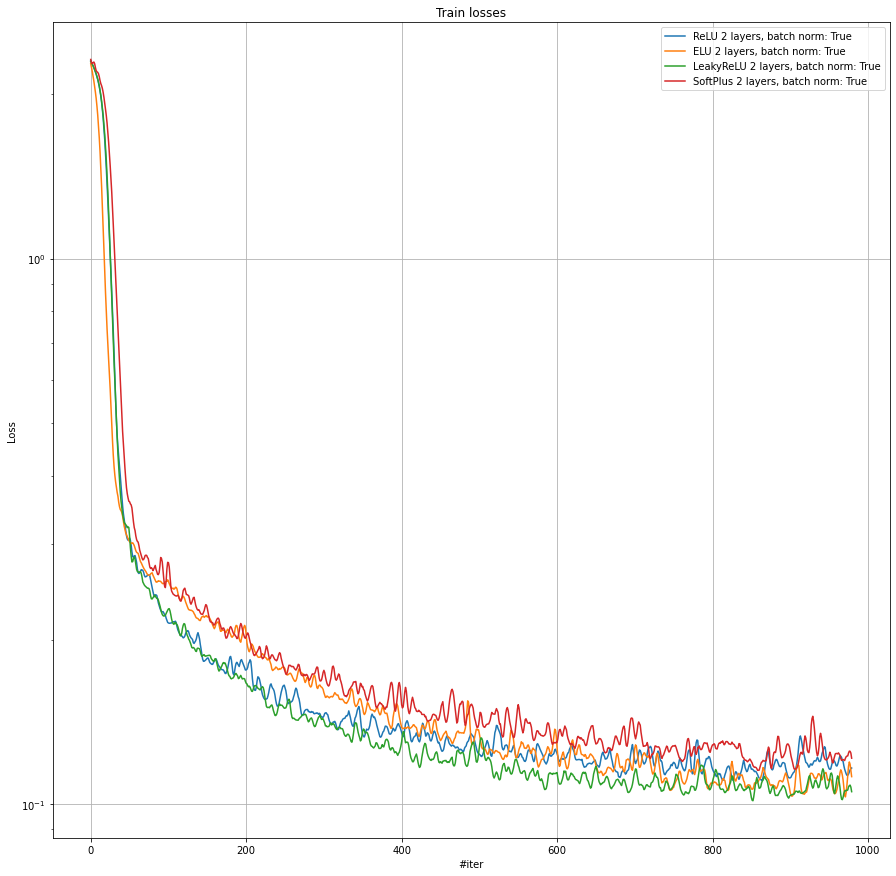

In [159]:
plot_losses(all_losses_2_bn_bs_val)

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Добавим dropout слой с дефолтной вероятностью 0.5.

In [162]:
def best_net(activation, batch_norm = None, dropout=None):
    net = Sequential()
    net.add(Linear(n_features, 100))
    
    if batch_norm:
        net.add(BatchNormalization(alpha=batch_norm))
        net.add(ChannelwiseScaling(100))
    
    net.add(activation())
    
    if dropout:
        net.add(Dropout(p=dropout))
    
    net.add(Linear(100, n_classes))
    net.add(LogSoftMax())
    return net

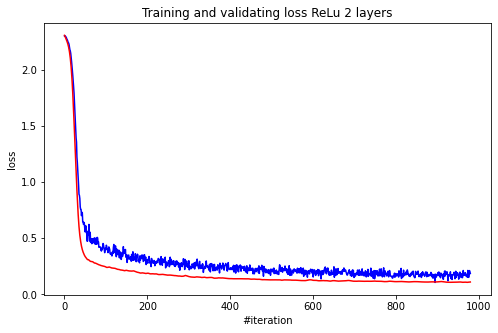

100%|███████████████████████████████████████████| 20/20 [01:44<00:00,  5.21s/it]

Current validation loss: 0.10991258000901623, train loss: 0.18563101691648726
CPU times: user 1min 39s, sys: 5.08 s, total: 1min 44s
Wall time: 1min 44s


In [163]:
%%time
best_net_losses = []

net = best_net(ReLU, batch_norm=0.9, dropout=0.5)
losses = val_train_loop(net, X_train, y_train, X_val=X_val, Y_val=y_val, name=f'ReLu 2 layers', 
                        batch_size=1024, n_epoch=20)


Print here your accuracy on test set. It should be around 90%.

In [164]:
from sklearn.metrics import accuracy_score

In [167]:
net.evaluate()
test_predictions = net.forward(X_test)
y_pred = np.argmax(test_predictions, axis=1)

print(f'Final test accuracy score:{accuracy_score(y_pred, y_test)}')

Final test accuracy score:0.9675


Это отличный результат, картинки, которые модель никогда не видела она смогла правильно классифицировать почти в 97 процентах. Однако не стоит забывать, что mnist это такой датасет, на котором у всех все работает, а на другом пробовать страшно :).  

Ширина слоя была подобрана, результат гораздо лучше, чем на условых 5, при этос подсчет ощутимо быстрее, чем при 200.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [168]:
import torch
from torch import nn

In [169]:
def get_torch_model():
    net = torch.nn.Sequential(
    nn.Linear(n_features, 100),
    nn.BatchNorm1d(100, eps=BatchNormalization.EPS, momentum=1-0.9, affine=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(100, n_classes),
    nn.LogSoftmax()
    )
    return net

In [176]:
import tqdm

def val_train_loop_torch(net, X, Y, X_val, Y_val, name, n_epoch=10, batch_size=32, criterion = nn.NLLLoss()):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    loss_history = []
    val_loss_history = []
    
    for i in tqdm.tqdm(range(n_epoch)):
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            x_batch = torch.FloatTensor(x_batch)
            y_batch = torch.FloatTensor(y_batch)
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion(predictions, y_batch.argmax(axis=1))

            # Backward
            dp = criterion(predictions, y_batch.argmax(axis=1))
            
            dp.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_history.append(loss)
            
            net.eval()
            X_val = torch.FloatTensor(X_val)
            Y_val = torch.FloatTensor(Y_val)
            val_predictions = net.forward(X_val)
            val_loss = criterion(val_predictions, Y_val.argmax(axis=1))
            val_loss_history.append(val_loss)
            net.train()

        print('Current validation loss: %f' % val_loss)
        
    return val_loss_history

In [177]:
torch_net = get_torch_model()

In [178]:
torch_net_losses = []
losses = val_train_loop_torch(torch_net, X_train, y_train, X_val=X_val, Y_val=y_val, name=f'ReLu 2 layers', 
                        batch_size=1024, n_epoch=20)

  0%|                                                    | 0/20 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  5%|██▏                                         | 1/20 [00:02<00:38,  2.03s/it]

Current validation loss: 0.477883


 10%|████▍                                       | 2/20 [00:04<00:36,  2.04s/it]

Current validation loss: 0.332425


 15%|██████▌                                     | 3/20 [00:06<00:33,  1.99s/it]

Current validation loss: 0.286741


 20%|████████▊                                   | 4/20 [00:08<00:31,  2.00s/it]

Current validation loss: 0.260584


 25%|███████████                                 | 5/20 [00:10<00:31,  2.08s/it]

Current validation loss: 0.242419


 30%|█████████████▏                              | 6/20 [00:12<00:31,  2.22s/it]

Current validation loss: 0.231437


 35%|███████████████▍                            | 7/20 [00:14<00:28,  2.16s/it]

Current validation loss: 0.219495


 40%|█████████████████▌                          | 8/20 [00:16<00:24,  2.06s/it]

Current validation loss: 0.211219


 45%|███████████████████▊                        | 9/20 [00:18<00:22,  2.03s/it]

Current validation loss: 0.201222


 50%|█████████████████████▌                     | 10/20 [00:20<00:19,  1.98s/it]

Current validation loss: 0.195366


 55%|███████████████████████▋                   | 11/20 [00:22<00:17,  1.98s/it]

Current validation loss: 0.188705


 60%|█████████████████████████▊                 | 12/20 [00:24<00:16,  2.07s/it]

Current validation loss: 0.185476


 65%|███████████████████████████▉               | 13/20 [00:26<00:14,  2.05s/it]

Current validation loss: 0.178062


 70%|██████████████████████████████             | 14/20 [00:28<00:11,  1.97s/it]

Current validation loss: 0.173250


 75%|████████████████████████████████▎          | 15/20 [00:30<00:09,  1.94s/it]

Current validation loss: 0.170673


 80%|██████████████████████████████████▍        | 16/20 [00:32<00:07,  1.93s/it]

Current validation loss: 0.166012


 85%|████████████████████████████████████▌      | 17/20 [00:34<00:05,  1.91s/it]

Current validation loss: 0.163382


 90%|██████████████████████████████████████▋    | 18/20 [00:36<00:03,  1.91s/it]

Current validation loss: 0.157521


 95%|████████████████████████████████████████▊  | 19/20 [00:37<00:01,  1.92s/it]

Current validation loss: 0.155069


100%|███████████████████████████████████████████| 20/20 [00:39<00:00,  1.99s/it]

Current validation loss: 0.153485


In [179]:
torch_net.eval()
test_predictions = torch_net.forward(torch.FloatTensor(X_test))
y_pred = test_predictions.argmax(axis=1)
print(f'Final test accuracy score:{accuracy_score(y_pred, y_test)}')

Final test accuracy score:0.9545


Ура, построили сеть, которая сравнима с torch моделью с такой же архитектурой.